In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from adapters import *
from dataset import NumpyCsvDataSet
from runner import ExptRunner
from networks.autoencoder import AutoEncoder
from networks.composedautoencoder import ComposedAutoEncoder
from networks.DenseAutoEncoder import DenseAutoEncoder
from networks.ConvVae import ConvVae
from networks.vae import VAE
from networks.etpr.autoencoder import autoencoder as etprautoenc
from networks.lossfunctions import *

In [4]:
opt = np.get_printoptions()
np.set_printoptions(threshold=np.inf)

In [5]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print (device)

cpu


In [22]:
start = time.time()
data_folder = 'data/demoplanner/version1'
v1_train_data = NumpyCsvDataSet(data_folder + '/train.csv', device=device)
v1_test_data = NumpyCsvDataSet(data_folder + '/test.csv', device=device)
print ("Time Taken: {} sec".format(time.time() - start))

Time Taken: 29.857527017593384 sec


In [19]:
start = time.time()
data_folder = 'data/demoplanner/version2'
v2_train_data = NumpyCsvDataSet(data_folder + '/train.csv', device=device)
v2_test_data = NumpyCsvDataSet(data_folder + '/test.csv', device=device)
print ("Time Taken: {} sec".format(time.time() - start))

Time Taken: 301.2297029495239 sec


In [23]:
train_data = v1_train_data
test_data = v1_test_data

In [24]:
print (train_data.data.shape)
print (test_data.data.shape)

print (train_data.data.device)
print (test_data.data.device)

torch.Size([13280, 2058])
torch.Size([1341, 2058])
cpu
cpu


In [84]:
expts = [
    ['DemoPl-V1-EtprEncoder-SmoothL1-', etprautoenc, demopl_v1_data_adapter, smooth_l1_loss_adapter, demopl_v1_data_to_img],
    # The difference between above and below should be only sigmoid at the end
    ['DemoPl-V1-ComposedAutoEncoderWithMaxPool-SmoothL1-', lambda: ComposedAutoEncoder(useMaxPool=True, layers_channels=[16,16,16]), demopl_v1_data_adapter, smooth_l1_loss_adapter, demopl_v1_data_to_img],
#     ['DemoPl-V1-ComposedAutoEncoderNoMaxPool-MSE-', ComposedAutoEncoder, demopl_v1_data_adapter, mse_loss_adapter, demopl_v1_data_to_img],
#     ['DemoPl-V1-ComposedAutoEncoderNoMaxPool-SmoothL1-', ComposedAutoEncoder, demopl_v1_data_adapter, smooth_l1_loss_adapter, demopl_v1_data_to_img],
#     ['DemoPl-V1-ComposedAutoEncoderWithMaxPool-MSE-', lambda: ComposedAutoEncoder(useMaxPool=True), demopl_v1_data_adapter, mse_loss_adapter, demopl_v1_data_to_img],
#     ['DemoPl-V2-DenseAutoEncoder3-MSE-', lambda: DenseAutoEncoder(enc_layer_dims=[1024, 128, 16]), demopl_v1_data_adapter, mse_loss_adapter, demopl_v1_data_to_img],
#     ['DemoPl-V2-DenseAutoEncoder3-SmoothL1-', lambda: DenseAutoEncoder(enc_layer_dims=[1024, 128, 16]), demopl_v1_data_adapter, smooth_l1_loss_adapter, demopl_v1_data_to_img],
#     ['DemoPl-V2-VAE-VAELoss-', VAE, demopl_v1_data_adapter, vae_loss_adapter, demopl_v1_data_to_img],
#     ['DemoPl-V2-ConvVAE-VAELoss-', ConvVae, demopl_v1_data_adapter, vae_loss_adapter, demopl_v1_data_to_img],
]

In [ ]:
train_epochs = 200
for i in range(len(expts)):
    inputs = expts[i]
    net = inputs[1]()
    net = net.to(device)
    runner = ExptRunner(inputs[0], net, train_data, test_data, inputs[2], inputs[3], data_to_img_func=inputs[4])
    print ("Log folder for expt {}: {}".format(i, runner.log_folder))
    runner.train(train_epochs, shouldShowReconstruction=False)
    runner.test()

In [25]:
map_netname_net = {
    'ComposedAutoEncoderWithMaxPool': lambda: ComposedAutoEncoder(useMaxPool=True),
    'DenseAutoEncoder3': lambda: DenseAutoEncoder(enc_layer_dims=[1024, 128, 16]),
    'ComposedAutoEncoderNoMaxPool': lambda: ComposedAutoEncoder(useMaxPool=False),
    'VAE': VAE,
    'ConvVAE': ConvVae,
    'EtprEncoder': etprautoenc,
    '03-19-22-21-33-DemoPl-V2-DenseAutoEncoder3-MSE-': lambda: DenseAutoEncoder(enc_layer_dims=[1024, 128, 32]),
    '03-19-22-52-24-DemoPl-V2-DenseAutoEncoder3-SmoothL1-': lambda: DenseAutoEncoder(enc_layer_dims=[1024, 128, 32]),
    '03-23-18-42-55-DemoPl-V1-ComposedAutoEncoderWithMaxPool-SmoothL1-':
        lambda: ComposedAutoEncoder(useMaxPool=True, layers_channels=[16,16,16]),
    '03-23-22-33-20-DemoPl-V1-ComposedAutoEncoderWithMaxPool-SmoothL1-':
        lambda: ComposedAutoEncoder(useMaxPool=True, layers_channels=[16,16,16], useSigmoid=False),
    '03-23-22-46-55-DemoPl-V1-ComposedAutoEncoderWithMaxPool-SmoothL1-':
        lambda: ComposedAutoEncoder(useMaxPool=True, layers_channels=[16,16,16]),
    '03-23-23-37-06-DemoPl-V1-ComposedAutoEncoderWithMaxPool-SmoothL1-':
        lambda: ComposedAutoEncoder(useMaxPool=True, layers_channels=[16,16,16], useSigmoid=False),
    '03-23-23-50-36-DemoPl-V1-ComposedAutoEncoderWithMaxPool-SmoothL1-':
        lambda: ComposedAutoEncoder(useMaxPool=True, layers_channels=[16,16,16]),
    '03-24-11-43-07-DemoPl-V2-ComposedAutoEncoderWithMaxPool-SmoothL1-':
        lambda: ComposedAutoEncoder(useMaxPool=True, layers_channels=[16,16,16], useSigmoid=False),
    '03-24-13-35-43-DemoPl-V2-ComposedAutoEncoderWithMaxPool-SmoothL1-':
        lambda: ComposedAutoEncoder(useMaxPool=True, layers_channels=[16,16,16]),
}

In [26]:
def build_net(map_netname_net, rootdir='runs'):
    for filename in glob.iglob(rootdir + '/**/*.pth', recursive=True):
        folder = os.path.basename(os.path.dirname(filename))
        parts = folder.split('-')
        netname = parts[7]
        if folder in map_netname_net.keys():
            net = map_netname_net[folder]()
        elif netname in map_netname_net.keys():
            net = map_netname_net[netname]()
        else:
            continue
        net.load_state_dict(torch.load(filename, map_location=device))
        yield folder, net

def show_test_samples(data, map_netname_net, rootdir='runs'):
    for folder, net in build_net(map_netname_net, rootdir):
        parts = folder.split('-')
        netname = parts[7]
        loss_adapter = vae_smooth_l1_loss_adapter if netname.lower().find('vae') >= 0 else smooth_l1_loss_adapter
        with torch.no_grad():
            criterion = nn.SmoothL1Loss()
            rows = min(5, len(data))
            ip_batch = demopl_v1_data_adapter(data[:rows])
            op_batch, _ = loss_adapter(net, ip_batch)
            for i in range(rows):
                print('datapoint', str(i), 'test error', criterion(input=ip_batch[i], target=op_batch[i]))
                plt.imshow(ip_batch[i].reshape(32,32), cmap=plt.get_cmap("gray"), vmin=0, vmax=1)
                plt.show()
                plt.imshow(op_batch[i].reshape(32,32), cmap=plt.get_cmap("gray"), vmin=0, vmax=1)
                plt.show()

def generate_csv_comparison_report(data, map_netname_net, rootdir='runs'):
    for folder, net in build_net(map_netname_net, rootdir):
        parts = folder.split('-')
        netname = parts[7]
        loss_adapter = vae_smooth_l1_loss_adapter if netname.lower().find('vae') >= 0 else smooth_l1_loss_adapter
        ip_batch = demopl_v1_data_adapter(data)
        op_batch, loss = loss_adapter(net, ip_batch)
        
        time = str.join(':', parts[:5])
        dataset = str.join('-', parts[5:7])
        losstype = parts[8]
        print ('{},{},{},{},{}'.format(time, dataset, netname, losstype, loss.item()))

In [27]:
test_data_float = test_data.data.float()
train_data_float = train_data.data.float()

In [28]:
generate_csv_comparison_report(test_data_float, map_netname_net)

03:24:09:42:31,DemoPl-V2,EtprEncoder,SmoothL1,0.00012992184201721102
03:24:11:43:07,DemoPl-V2,ComposedAutoEncoderWithMaxPool,SmoothL1,0.000143768877023831
03:24:13:35:43,DemoPl-V2,ComposedAutoEncoderWithMaxPool,SmoothL1,6.0987604229012504e-05
03:23:22:33:20,DemoPl-V1,ComposedAutoEncoderWithMaxPool,SmoothL1,0.0005683465278707445
03:23:22:46:55,DemoPl-V1,ComposedAutoEncoderWithMaxPool,SmoothL1,0.01493978500366211
03:23:22:19:55,DemoPl-V1,EtprEncoder,SmoothL1,0.0005149825592525303
03:23:23:50:36,DemoPl-V1,ComposedAutoEncoderWithMaxPool,SmoothL1,0.01493978500366211
03:23:23:37:06,DemoPl-V1,ComposedAutoEncoderWithMaxPool,SmoothL1,0.0002839696535374969
03:23:23:23:53,DemoPl-V1,EtprEncoder,SmoothL1,0.00035312457475811243
03:23:18:42:55,DemoPl-V1,ComposedAutoEncoderWithMaxPool,SmoothL1,0.004924631677567959
03:23:17:45:55,DemoPl-V1,EtprEncoder,SmoothL1,0.00037207582499831915
03:17:18:57:21,DemoPl-V1,ComposedAutoEncoderWithMaxPool,SmoothL1,0.0016718709375709295
03:17:19:22:49,DemoPl-V1,DenseAuto

In [12]:
generate_csv_comparison_report(train_data_float, map_netname_net)

03:24:09:42:31,DemoPl-V2,EtprEncoder,SmoothL1,0.00012699307990260422
03:24:11:43:07,DemoPl-V2,ComposedAutoEncoderWithMaxPool,SmoothL1,0.0001438569015590474
03:24:13:35:43,DemoPl-V2,ComposedAutoEncoderWithMaxPool,SmoothL1,6.118665623944253e-05
03:23:22:33:20,DemoPl-V1,ComposedAutoEncoderWithMaxPool,SmoothL1,0.0005476292571984231
03:23:22:46:55,DemoPl-V1,ComposedAutoEncoderWithMaxPool,SmoothL1,0.014938977546989918
03:23:22:19:55,DemoPl-V1,EtprEncoder,SmoothL1,0.0004824305942747742
03:23:23:50:36,DemoPl-V1,ComposedAutoEncoderWithMaxPool,SmoothL1,0.014938977546989918
03:23:23:37:06,DemoPl-V1,ComposedAutoEncoderWithMaxPool,SmoothL1,0.0002485710720065981
03:23:23:23:53,DemoPl-V1,EtprEncoder,SmoothL1,0.00031048839446157217
03:23:18:42:55,DemoPl-V1,ComposedAutoEncoderWithMaxPool,SmoothL1,0.0047915480099618435
03:23:17:45:55,DemoPl-V1,EtprEncoder,SmoothL1,0.00034551427233964205
03:17:18:57:21,DemoPl-V1,ComposedAutoEncoderWithMaxPool,SmoothL1,0.001541651552543044
03:17:19:22:49,DemoPl-V1,DenseAu

datapoint 0 test error tensor(1.0321e-05)


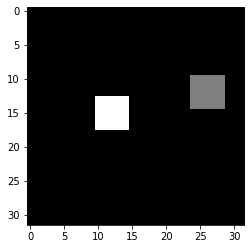

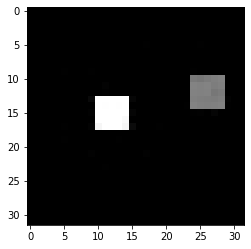

datapoint 1 test error tensor(9.3018e-06)


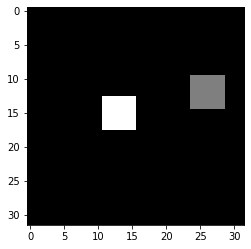

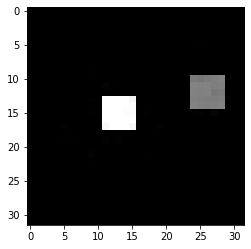

datapoint 2 test error tensor(2.5402e-05)


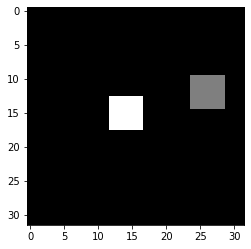

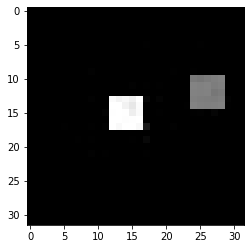

datapoint 3 test error tensor(1.9388e-05)


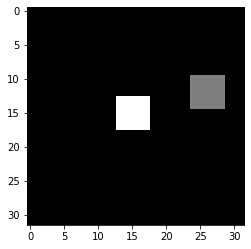

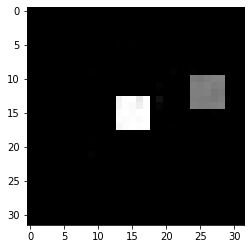

datapoint 4 test error tensor(4.5433e-05)


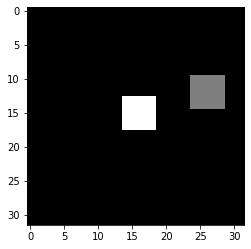

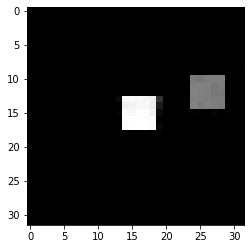

In [30]:
show_test_samples(test_data_float, map_netname_net,
                  rootdir='runs/03-24/03-24-09-42-31-DemoPl-V2-EtprEncoder-SmoothL1-')

datapoint 0 test error tensor(4.5541e-05)


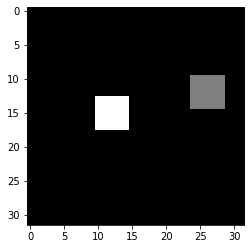

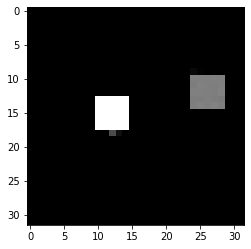

datapoint 1 test error tensor(1.1674e-06)


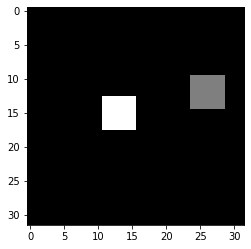

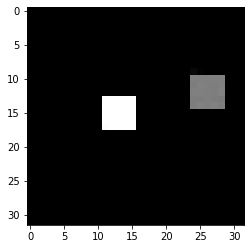

datapoint 2 test error tensor(1.1636e-06)


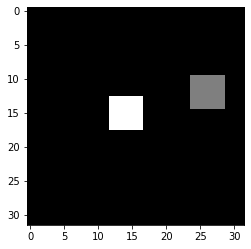

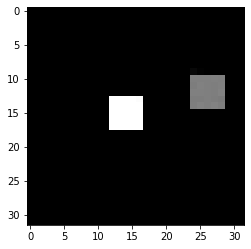

datapoint 3 test error tensor(1.5354e-06)


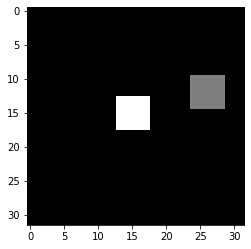

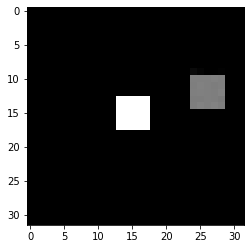

datapoint 4 test error tensor(4.7894e-06)


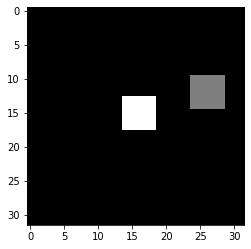

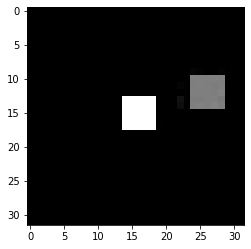

In [31]:
show_test_samples(test_data_float, map_netname_net,
                  rootdir='runs/03-24/03-24-13-35-43-DemoPl-V2-ComposedAutoEncoderWithMaxPool-SmoothL1-')

datapoint 0 test error tensor(2.4455e-05)


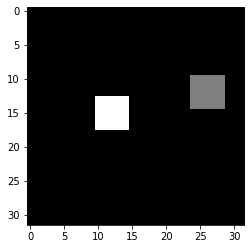

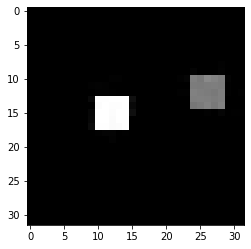

datapoint 1 test error tensor(1.6666e-05)


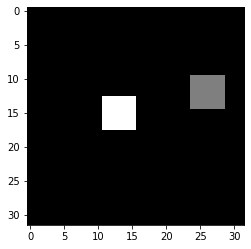

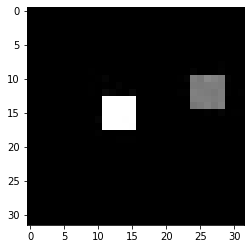

datapoint 2 test error tensor(4.3954e-05)


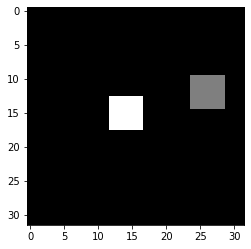

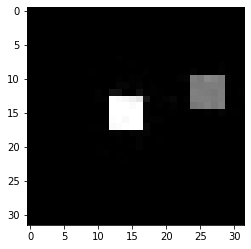

datapoint 3 test error tensor(7.3204e-05)


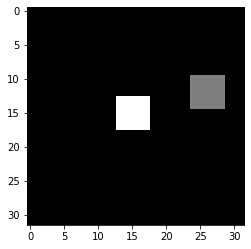

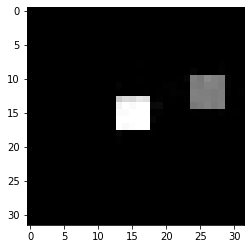

datapoint 4 test error tensor(5.5588e-05)


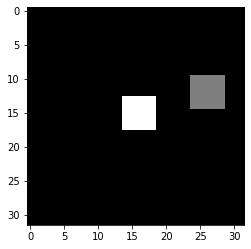

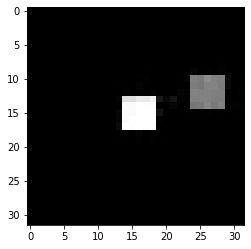

In [32]:
show_test_samples(test_data_float, map_netname_net,
                  rootdir='runs/03-24/03-24-11-43-07-DemoPl-V2-ComposedAutoEncoderWithMaxPool-SmoothL1-')

datapoint 0 test error tensor(0.0002)


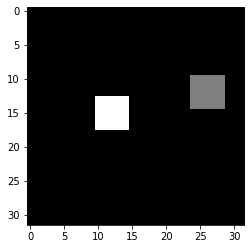

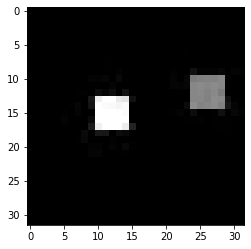

datapoint 1 test error tensor(0.0002)


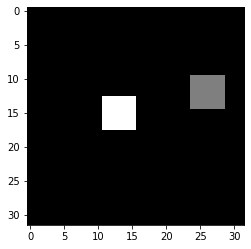

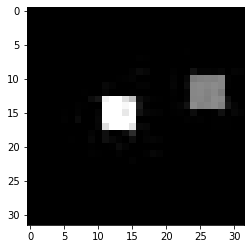

datapoint 2 test error tensor(0.0002)


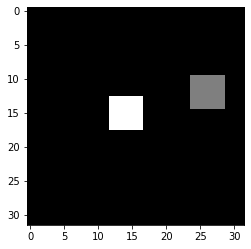

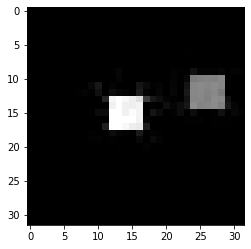

datapoint 3 test error tensor(0.0003)


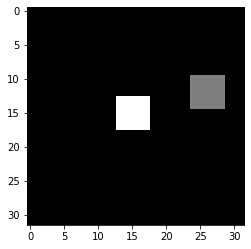

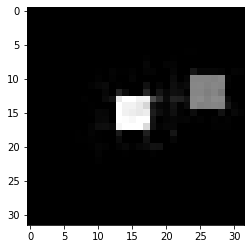

datapoint 4 test error tensor(0.0003)


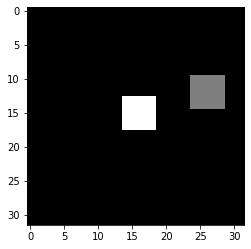

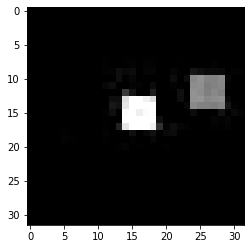

In [33]:
show_test_samples(test_data_float, map_netname_net,
                  rootdir='runs/03-23/run2/03-23-22-33-20-DemoPl-V1-ComposedAutoEncoderWithMaxPool-SmoothL1-')

Model File: runs/03-23/run3/03-23-23-37-06-DemoPl-V1-ComposedAutoEncoderWithMaxPool-SmoothL1-/autoenc.pth
Average loss over the entire dataset: 0.0002839696535374969
datapoint 0 test error tensor(5.8443e-05)


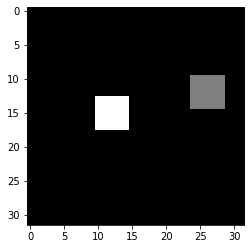

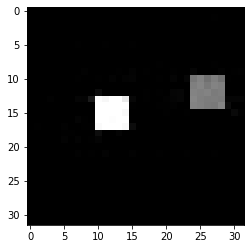

datapoint 1 test error tensor(7.3032e-05)


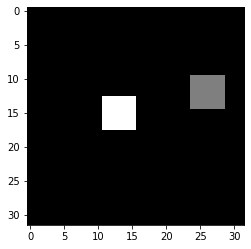

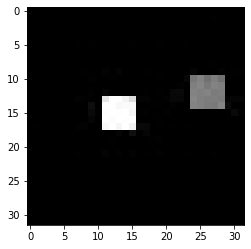

datapoint 2 test error tensor(7.7322e-05)


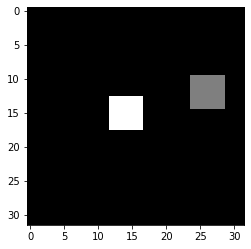

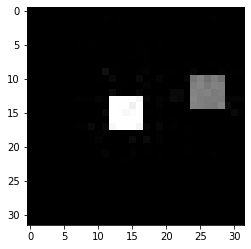

datapoint 3 test error tensor(9.9420e-05)


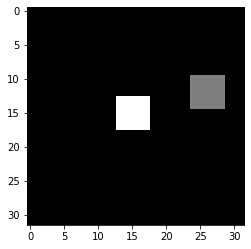

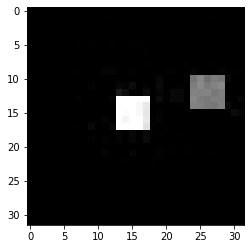

datapoint 4 test error tensor(9.5791e-05)


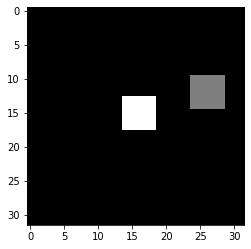

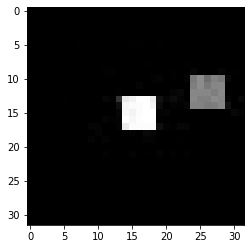

In [19]:
show_test_samples(test_data_float,
                  rootdir='runs/03-23/run3/03-23-23-37-06-DemoPl-V1-ComposedAutoEncoderWithMaxPool-SmoothL1-')

Model File: runs/03-19/03-19-17-40-38-DemoPl-V2-ComposedAutoEncoderWithMaxPool-MSE-/autoenc.pth
Average loss over the entire dataset: 0.0007207341259345412
datapoint 0 test error tensor(0.0003)


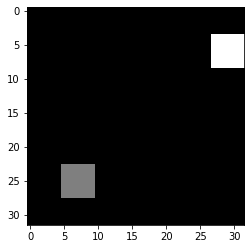

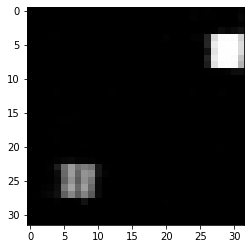

datapoint 1 test error tensor(0.0003)


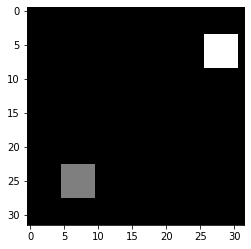

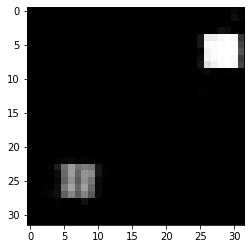

datapoint 2 test error tensor(0.0002)


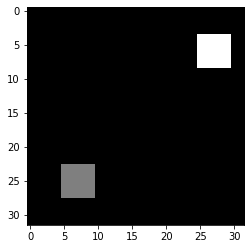

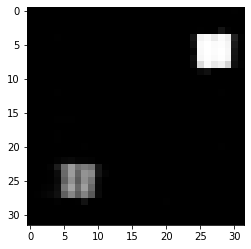

datapoint 3 test error tensor(0.0002)


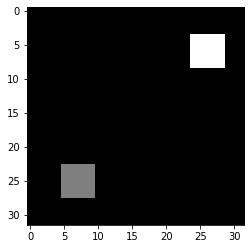

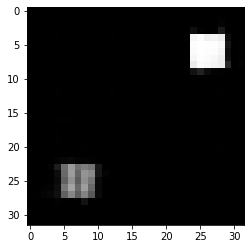

datapoint 4 test error tensor(0.0002)


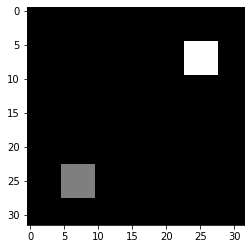

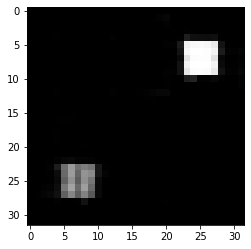

In [65]:
show_test_samples(test_data_float,
                  rootdir='runs/03-19/03-19-17-40-38-DemoPl-V2-ComposedAutoEncoderWithMaxPool-MSE-')

datapoint 0 test error tensor(0.0002)


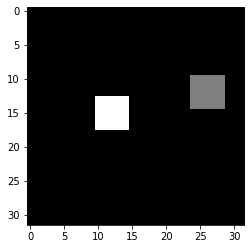

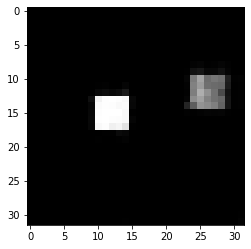

datapoint 1 test error tensor(0.0002)


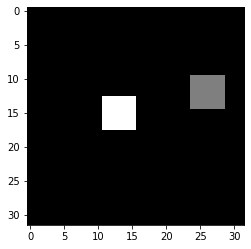

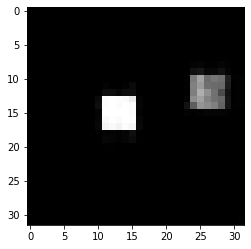

datapoint 2 test error tensor(0.0002)


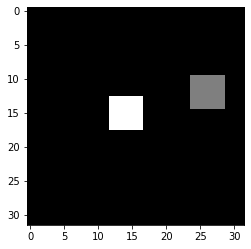

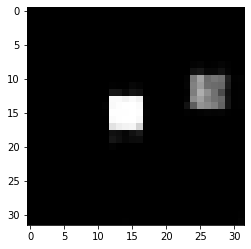

datapoint 3 test error tensor(0.0003)


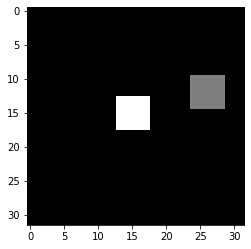

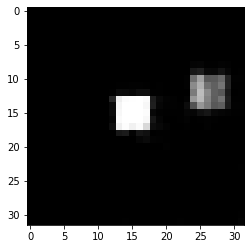

datapoint 4 test error tensor(0.0005)


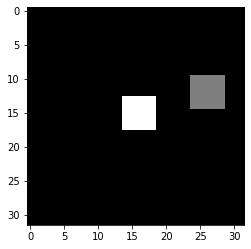

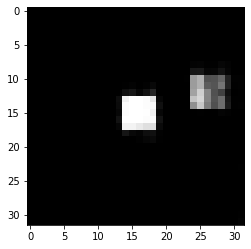

In [34]:
show_test_samples(test_data_float, map_netname_net,
                  rootdir='runs/03-18/03-18-17-45-23-DemoPl-V2-ComposedAutoEncoderNoMaxPool-SmoothL1-')

In [ ]:
np.set_printoptions(**opt)